<a href="https://colab.research.google.com/github/namanphy/EVA5/blob/main/S11/main_S11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setting up code

#### Cloning the required [repository](https://github.com/namanphy/EVA5/) and adding the path to the code directory.

In [ ]:
import sys

! git clone https://github.com/namanphy/EVA5.git
! pip install git+https://github.com/albumentations-team/albumentations.git

sys.path.append('EVA5/S11/')

#### Importing the required modules and files

In [ ]:
import cuda
from data.dataset import CIFAR10
from data.dataloader import data_loader
from model import ResModel
from model.optimizer import sgd_optimizer
from model.loss import cross_entropy_loss
from engine import Trainer
from utils import set_seed, plot_metric, identify_misclassification, plot_results
from engine.lr_finder import LRFinder
from engine.lr_scheduler import one_cycle_lr

In [ ]:
set_seed(123)
use_cuda = cuda.cuda_is_available()
device = cuda.enable_cuda()

## Making the data ready

In [ ]:
cifar10 = CIFAR10(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5), padding=(36, 36), crop=(32, 32), horizontal_flip=0.5, cutout=0.5, cutout_hw_ratio=4)

train_set = cifar10.download('../data', train=True, apply_transform=True)
test_set = cifar10.download('../data', train=False, apply_transform=True)

# Loading the datasets into Pytorch Dataloaders
train_loader = data_loader(train_set, 512, use_cuda, num_workers=16)
test_loader = data_loader(test_set, 512, use_cuda, num_workers=16)


Extracting ../data/cifar-10-python.tar.gz to ../data
Transforms :  {'train': True, 'mean': (0.5, 0.5, 0.5), 'std': (0.5, 0.5, 0.5), 'padding': (36, 36), 'crop': (32, 32), 'rotation': 0, 'horizontal_flip': 0.5, 'vertical_flip': 0.0, 'cutout': 0.5, 'cutout_height': 8, 'cutout_width': 8}


/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:645: FutureWarning: This class has been deprecated. Please use CoarseDropout
  FutureWarning,


Files already downloaded and verified
Transforms :  {'train': False, 'mean': (0.5, 0.5, 0.5), 'std': (0.5, 0.5, 0.5), 'padding': (36, 36), 'crop': (32, 32), 'rotation': 0, 'horizontal_flip': 0.5, 'vertical_flip': 0.0, 'cutout': 0.5, 'cutout_height': 8, 'cutout_width': 8}
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## Import model architecture

In [36]:
model = ResModel(num_classes=10, in_planes=3)
model.name = 'ResidualModel' # Giving my model a name
model.summary(input_size=(3, 32, 32), device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
            Conv2d-7          [-1, 128, 16, 16]         147,456
       BatchNorm2d-8          [-1, 128, 16, 16]             256
            Conv2d-9          [-1, 128, 16, 16]         147,456
      BatchNorm2d-10          [-1, 128, 16, 16]             256
    ResidualBlock-11          [-1, 128, 16, 16]               0
       BasicBlock-12          [-1, 128, 16, 16]               0
           Conv2d-13          [-1, 256, 16, 16]         294,912
        MaxPool2d-14            [-1, 25

## Setting up Training

In [37]:
'Total Images', len(train_loader)*512

('Total Images', 50176)

In [38]:
results = {}  # empty dict to store results

criterion = cross_entropy_loss()
optimizer = sgd_optimizer(model, lr=0.005, l2_factor=0.01)

#### Finding LR - using cyclic LR policy

In [39]:
start_lr = 0.0001
end_lr = 0.05
num_iter = len(train_loader) * 10

lr_finder = LRFinder(model, optimizer, criterion, device="cuda", metric='accuracy')
lr_finder.range_test(train_loader, start_lr=start_lr, end_lr=end_lr, num_iter=num_iter, step_mode='linear')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Learning rate search finished. See the graph with {finder_name}.plot()


LR suggestion: steepest gradient
Suggested LR: 1.72E-02


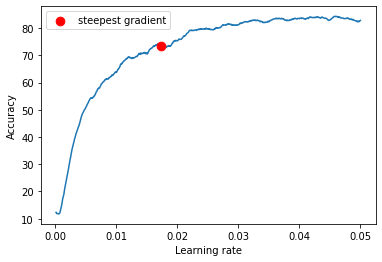

In [40]:
lr_finder.plot(skip_start=0, skip_end=0, log_lr=False)
lr_finder.reset()

LR suggestion: steepest gradient
Suggested LR: 1.72E-02


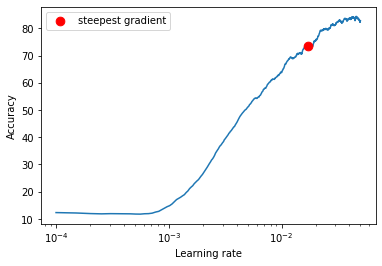

In [41]:
lr_finder.plot(skip_start=0, skip_end=0, log_lr=True)
lr_finder.reset()

Choosing the max LR from above as - **0.02**

#### Training Model

In [42]:
epochs = 24
steps_per_epoch = len(train_loader)
max_lr = 0.02

scheduler = one_cycle_lr(optimizer, max_lr, epochs=epochs, steps_per_epoch=steps_per_epoch, 
                         pct_start=5/epochs, div_factor=5, final_div_factor=1)


In [43]:
# Setting up the trainer
trainer = Trainer(model, optimizer, criterion, train_loader, valid_data_loader=test_loader,
                  callbacks=[scheduler], l1_loss=False)

results['resnet18'] = trainer.train(24)
trainer.save('cifar10_model')

  0%|          | 0/98 [00:00<?, ?it/s]

------------ EPOCH 1 -------------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=1.1470537185668945 Batch_id=97 Accuracy=45.97: 100%|██████████| 98/98 [00:28<00:00,  3.45it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.4459, Accuracy: 4983/10000 (50%)

------------ EPOCH 2 -------------


Loss=0.8900521397590637 Batch_id=97 Accuracy=65.29: 100%|██████████| 98/98 [00:27<00:00,  3.56it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.9146, Accuracy: 6738/10000 (67%)

------------ EPOCH 3 -------------


Loss=0.6655058860778809 Batch_id=97 Accuracy=73.82: 100%|██████████| 98/98 [00:27<00:00,  3.58it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.7134, Accuracy: 7486/10000 (75%)

------------ EPOCH 4 -------------


Loss=0.5601049661636353 Batch_id=97 Accuracy=78.86: 100%|██████████| 98/98 [00:27<00:00,  3.52it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.5809, Accuracy: 7978/10000 (80%)

------------ EPOCH 5 -------------


Loss=0.4991864562034607 Batch_id=97 Accuracy=81.66: 100%|██████████| 98/98 [00:27<00:00,  3.56it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.5422, Accuracy: 8163/10000 (82%)

------------ EPOCH 6 -------------


Loss=0.46764373779296875 Batch_id=97 Accuracy=83.90: 100%|██████████| 98/98 [00:27<00:00,  3.58it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.5124, Accuracy: 8203/10000 (82%)

------------ EPOCH 7 -------------


Loss=0.4634071886539459 Batch_id=97 Accuracy=85.97: 100%|██████████| 98/98 [00:27<00:00,  3.60it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.5097, Accuracy: 8259/10000 (83%)

------------ EPOCH 8 -------------


Loss=0.3555653989315033 Batch_id=97 Accuracy=87.16: 100%|██████████| 98/98 [00:27<00:00,  3.59it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.5485, Accuracy: 8187/10000 (82%)

------------ EPOCH 9 -------------


Loss=0.42975154519081116 Batch_id=97 Accuracy=88.73: 100%|██████████| 98/98 [00:27<00:00,  3.56it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4153, Accuracy: 8572/10000 (86%)

------------ EPOCH 10 -------------


Loss=0.3333973288536072 Batch_id=97 Accuracy=89.46: 100%|██████████| 98/98 [00:27<00:00,  3.57it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4347, Accuracy: 8552/10000 (86%)

------------ EPOCH 11 -------------


Loss=0.3864227831363678 Batch_id=97 Accuracy=90.28: 100%|██████████| 98/98 [00:27<00:00,  3.59it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4586, Accuracy: 8433/10000 (84%)

------------ EPOCH 12 -------------


Loss=0.250760555267334 Batch_id=97 Accuracy=90.57: 100%|██████████| 98/98 [00:27<00:00,  3.58it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4230, Accuracy: 8586/10000 (86%)

------------ EPOCH 13 -------------


Loss=0.3002587854862213 Batch_id=97 Accuracy=90.99: 100%|██████████| 98/98 [00:27<00:00,  3.56it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4072, Accuracy: 8572/10000 (86%)

------------ EPOCH 14 -------------


Loss=0.22057612240314484 Batch_id=97 Accuracy=91.90: 100%|██████████| 98/98 [00:27<00:00,  3.55it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.3868, Accuracy: 8701/10000 (87%)

------------ EPOCH 15 -------------


Loss=0.2606865167617798 Batch_id=97 Accuracy=92.06: 100%|██████████| 98/98 [00:27<00:00,  3.58it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.3797, Accuracy: 8701/10000 (87%)

------------ EPOCH 16 -------------


Loss=0.22081361711025238 Batch_id=97 Accuracy=92.65: 100%|██████████| 98/98 [00:27<00:00,  3.61it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.3383, Accuracy: 8836/10000 (88%)

------------ EPOCH 17 -------------


Loss=0.2549535930156708 Batch_id=97 Accuracy=92.55: 100%|██████████| 98/98 [00:27<00:00,  3.57it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.3476, Accuracy: 8816/10000 (88%)

------------ EPOCH 18 -------------


Loss=0.18400831520557404 Batch_id=97 Accuracy=93.33: 100%|██████████| 98/98 [00:27<00:00,  3.57it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4224, Accuracy: 8600/10000 (86%)

------------ EPOCH 19 -------------


Loss=0.22104176878929138 Batch_id=97 Accuracy=93.30: 100%|██████████| 98/98 [00:27<00:00,  3.57it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.3574, Accuracy: 8785/10000 (88%)

------------ EPOCH 20 -------------


Loss=0.18974079191684723 Batch_id=97 Accuracy=93.84: 100%|██████████| 98/98 [00:27<00:00,  3.58it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.3818, Accuracy: 8737/10000 (87%)

------------ EPOCH 21 -------------


Loss=0.24697932600975037 Batch_id=97 Accuracy=93.83: 100%|██████████| 98/98 [00:27<00:00,  3.57it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4049, Accuracy: 8687/10000 (87%)

------------ EPOCH 22 -------------


Loss=0.1736430525779724 Batch_id=97 Accuracy=93.86: 100%|██████████| 98/98 [00:27<00:00,  3.57it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.3426, Accuracy: 8819/10000 (88%)

------------ EPOCH 23 -------------


Loss=0.18037928640842438 Batch_id=97 Accuracy=94.14: 100%|██████████| 98/98 [00:27<00:00,  3.57it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.3412, Accuracy: 8857/10000 (89%)

------------ EPOCH 24 -------------


Loss=0.21087801456451416 Batch_id=97 Accuracy=94.30: 100%|██████████| 98/98 [00:27<00:00,  3.57it/s]



Test set: Average loss: 0.3142, Accuracy: 8951/10000 (90%)



## Analyzing results 

In [44]:
from statistics import mean
print('Train accuracy - ',  max(results['resnet18']['train_acc']))
print('Test accuracy - ',  max(results['resnet18']['test_acc']))

Train accuracy -  94.296
Test accuracy -  89.51


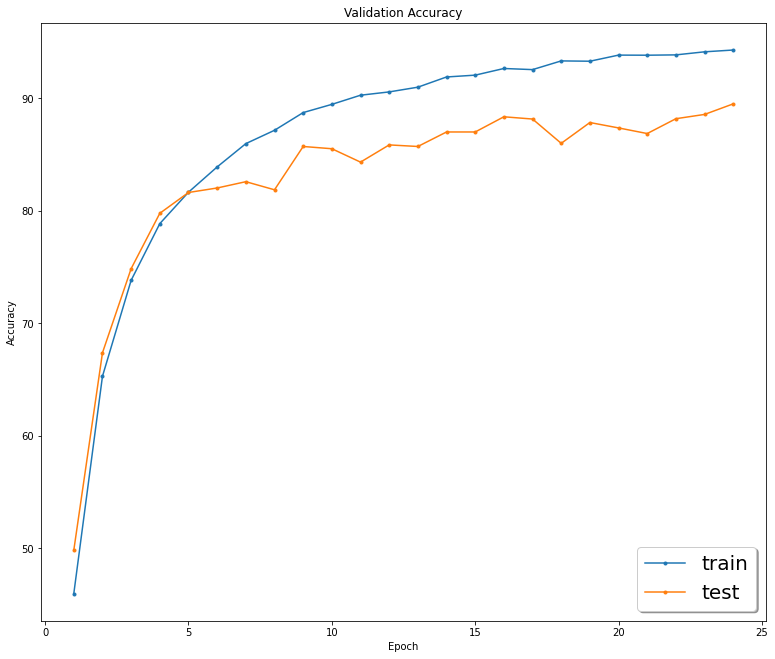

In [45]:
plot_metric({'train': results['resnet18']['train_acc'], 'test': results['resnet18']['test_acc']}, 'Accuracy')